Trial 2 Complete [00h 08m 01s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 20m 32s

The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 64,
the optimal kernel size for the first convolutional layer is 5,
the optimal number of filters in the second convolutional layer is 64,
the optimal kernel size for the second convolutional layer is 5,
the optimal number of units in the dense layer is 64,
the optimal dropout rate is 0.1,
and the optimal learning rate for the optimizer is 0.0001.

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 829ms/step - accuracy: 0.7373 - loss: 0.5548 - val_accuracy: 0.7500 - val_loss: 0.5117 - learning_rate: 1.0000e-04
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 858ms/step - accuracy: 0.8556 - loss: 0.3322 - val_accuracy: 0.8125 - val_loss: 0.4894 - learning_rate: 1.0000e-04
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 840ms/step - accuracy: 0.8729 - loss: 0.2918 - val_accuracy: 0.75

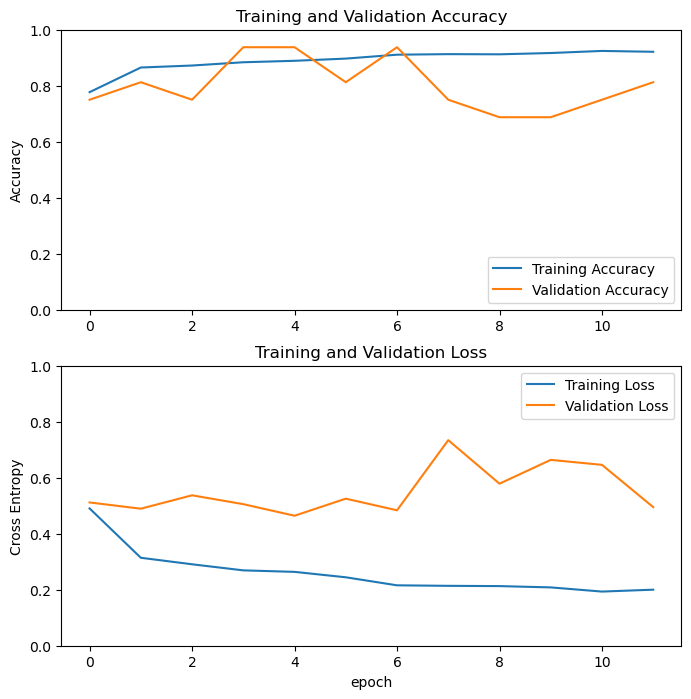

In [4]:
# Install keras-tuner if not already installed
import sys
!{sys.executable} -m pip install keras-tuner

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
import matplotlib.pyplot as plt
import cv2
import os

# Define constants
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Function to get data from directory
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Ensure the image is read correctly
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load data
train = get_data('../../chest_xray/train')
val = get_data('../../chest_xray/val')

# Separate features and labels
x_train, y_train = [], []
x_val, y_val = [], []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0

# Reshape data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

# Hypermodel function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), kernel_size=hp.Choice('conv_1_kernel', values=[3,5]), activation='relu', input_shape=(img_size, img_size, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16), kernel_size=hp.Choice('conv_2_kernel', values=[3,5]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Keras Tuner with limited trials and epochs
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=2,  # Limit the number of trials
                        executions_per_trial=1,  # Average results over multiple executions
                        directory='hyperparam_tuning',
                        project_name='chest_xray_tuning')

# Callback for reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-5)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

# Hyperparameter search
tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,  # Limit the number of epochs
             validation_data=(x_val, y_val),
             callbacks=[reduce_lr])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('conv_1_filter')},
the optimal kernel size for the first convolutional layer is {best_hps.get('conv_1_kernel')},
the optimal number of filters in the second convolutional layer is {best_hps.get('conv_2_filter')},
the optimal kernel size for the second convolutional layer is {best_hps.get('conv_2_kernel')},
the optimal number of units in the dense layer is {best_hps.get('dense_1_units')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=12,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr])

# Save the model and training history
model.save("cnn_tuned_model.h5")
np.save('tuned_training_history.npy', history.history)

# Plot training & validation accuracy values
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()